# Generating a Solar Wind Population Distribution

In [1]:
%matplotlib inline

In [2]:
# Import packages
import matplotlib
#matplotlib.rc('text', usetex=True)
import matplotlib.pyplot as plt
import matplotlib.image
import seaborn as sb
import numpy as np
import scipy.stats as stats
import scipy.constants as consts
import scipy.ndimage
import scipy

## Velocity distribution functions (VDFs)

$$ f = f_{c} + f_{h} + f_{s} $$

Where $f_{c}$ is the bi-Maxwellian function for the core, $f_{h}$ is the bi-kappa function for the halo and $f_{s}$ is the analytical bi-kappa formula for the strahl.

Equations for the above distributions can be found in https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2008JA013883 for $f_{c}$ and $f_{s}$ and in https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2005JA011119 for $f_{h}$.

Core:

In [13]:
# Distribution function for a bi-Maxwellellian core distribution with density n [m^-3], temperature kT [eV],
# velocity v0 [km/s], direction of flow (th0,ph0) [deg], for a species of mass m [u], charge state q [dimensionless integer],
# at energies per charge EperQ [eV/q], look direction (th,ph) [deg]. Returns the value of the distribution function
# in units of s^3/m^6 at the velocity (vx,vy,vz) [m/s] - note the different units for velocity.
def dist_c(m, q, n, v0, th0, ph0, kT, v, th, ph, delta_c):
    v0x = v0*1e3*np.cos(ph0*np.pi/180.0)*np.sin(th0*np.pi/180.0)
    v0y = v0*1e3*np.sin(ph0*np.pi/180.0)*np.sin(th0*np.pi/180.0)
    v0z = v0*1e3*np.cos(th0*np.pi/180.0)
    #v = np.sqrt(2.0*q*EperQ*consts.e/(m*consts.u))
    vx = v*np.cos(ph*np.pi/180.0)*np.sin(th*np.pi/180.0)
    vy = v*np.sin(ph*np.pi/180.0)*np.sin(th*np.pi/180.0)
    vz = v*np.cos(th*np.pi/180.0)
    #x = 0.5*m*consts.u*v0*v0*1e6 + EperQ*consts.e*q - m*consts.u*(v0x*vx + v0y*vy + v0z*vz)
#x = 0.5*m*consts.u*((v0x-vx)**2 + (v0y-vy)**2 + (v0z-vz)**2)
    return (n*((m*consts.u)/(2.0*np.pi*kT*consts.e))**(1.5))*np.exp((-(m*consts.u)/2.0)*(((v**2)/(kT*consts.e))+((v-delta_c)**2)/(kT*consts.e)))

# Functions to convert from distribution function to flux units (both differential energy flux and differential number flux)
# f in units of s^3 m^-6, EperQ in units of eV/q, m in units of u, and q is an integer
dnf_c = lambda f, v, m: f*(v**2)/m
def_c = lambda f, v, m: f*(v**4)/(2*m)

Halo:

In [14]:
# Distribution function for a bi-kappa halo distribution with a kappa paramter if 4 at 1 AU, density n [m^-3], temperature kT [eV],
# velocity v0 [km/s], direction of flow (th0,ph0) [deg], for a species of mass m [u], charge state q [dimensionless integer],
# at energies per charge EperQ [eV/q], look direction (th,ph) [deg]. Returns the value of the distribution function
# in units of s^3/m^6 at the velocity (vx,vy,vz) [m/s] - note the different units for velocity.
def dist_h(m, q, n, v0, th0, ph0, kT, v, th, ph, delta_h):
    v0x = v0*1e3*np.cos(ph0*np.pi/180.0)*np.sin(th0*np.pi/180.0)
    v0y = v0*1e3*np.sin(ph0*np.pi/180.0)*np.sin(th0*np.pi/180.0)
    v0z = v0*1e3*np.cos(th0*np.pi/180.0)
    #v = np.sqrt(2.0*q*EperQ*consts.e/(m*consts.u))
    vx = v*np.cos(ph*np.pi/180.0)*np.sin(th*np.pi/180.0)
    vy = v*np.sin(ph*np.pi/180.0)*np.sin(th*np.pi/180.0)
    vz = v*np.cos(th*np.pi/180.0)
    #x = 0.5*m*consts.u*v0*v0*1e6 + EperQ*consts.e*q - m*consts.u*(v0x*vx + v0y*vy + v0z*vz)
    #x = 0.5*m*consts.u*((v0x-vx)**2 + (v0y-vy)**2 + (v0z-vz)**2)
    kappa_h = 4.0
    gamma_h = scipy.special.gamma(kappa_h)
    V = np.sqrt(kT*consts.e*(2*kappa_h-5)/(kappa_h*m*consts.u))
    A = n*gamma_h/((scipy.special.gamma(kappa_h-1.5)*(V**3))*(np.pi*kappa_h)**1.5)
    return A*(1+(2*(v**2))/(kappa_h*(V**2)))**(-kappa_h)


# Functions to convert from distribution function to flux units (both differential energy flux and differential number flux)
# f in units of s^3 m^-6, EperQ in units of eV/q, m in units of u, and q is an integer
dnf_h = lambda f, v, m: f*(v**2)/m
def_h = lambda f, v, m: f*(v**4)/(2*m)

Strahl:

In [15]:
# Distribution function for a bi-kappa strahl distribution with a kappa paramter if 4 at 1 AU, density n [m^-3], temperature kT [eV],
# velocity v0 [km/s], direction of flow (th0,ph0) [deg], for a species of mass m [u], charge state q [dimensionless integer],
# at energies per charge EperQ [eV/q], look direction (th,ph) [deg]. Returns the value of the distribution function
# in units of s^3/m^6 at the velocity (vx,vy,vz) [m/s] - note the different units for velocity.
def dist_s(m, q, n, v0, th0, ph0, kT, v, th, ph, delta_s, D):
    v0x = v0*1e3*np.cos(ph0*np.pi/180.0)*np.sin(th0*np.pi/180.0)
    v0y = v0*1e3*np.sin(ph0*np.pi/180.0)*np.sin(th0*np.pi/180.0)
    v0z = v0*1e3*np.cos(th0*np.pi/180.0)
    #v = np.sqrt(2.0*q*EperQ*consts.e/(m*consts.u))
    vx = v*np.cos(ph*np.pi/180.0)*np.sin(th*np.pi/180.0)
    vy = v*np.sin(ph*np.pi/180.0)*np.sin(th*np.pi/180.0)
    vz = v*np.cos(th*np.pi/180.0)
    #x = 0.5*m*consts.u*v0*v0*1e6 + EperQ*consts.e*q - m*consts.u*(v0x*vx + v0y*vy + v0z*vz)
    #x = 0.5*m*consts.u*((v0x-vx)**2 + (v0y-vy)**2 + (v0z-vz)**2)
    kappa_s = 4.0
    Theta = 10
    
    return (2*np.sqrt(Theta)/np.sqrt(Theta+1))*(n*((m*consts.u)/(np.pi*kT*consts.e*(2*kappa_s-3)))**(1.5))*(scipy.special.gamma(kappa_s+1)/scipy.special.gamma(kappa_s-0.5))*(1+(m*consts.u/(2*kappa_s-3))*((v**2)/(kT*consts.e)+D*((v-delta_s)**2)/(kT*consts.e)))**(-kappa_s-1)
    
# Functions to convert from distribution function to flux units (both differential energy flux and differential number flux)
# f in units of s^3 m^-6, EperQ in units of eV/q, m in units of u, and q is an integer
dnf_s = lambda f, v, m: f*(v**2)/m
def_s = lambda f, v, m: f*(v**4)/(2*m)

Generate a solar wind spectrum moving at 450 km/s. We build a distribution before we do this.
Assume core density of 10${^8}$ m$^{-3}$ and temperature of 5x10${^5}$ K https://arxiv.org/abs/1603.08392, halo density of 5x10${^6}$ m$^{-3}$ https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2005JA011119 and temperature of 1x10${^6}$ K https://arxiv.org/abs/1603.08392 and strahl density and temperature of 5x10${^6}$ m$^{-3}$ and 1x10${^6}$ K respectively https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1002/2016JA023656.

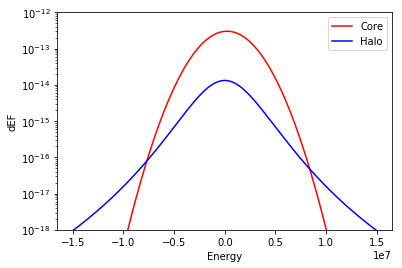

In [20]:
# Define some parameters of the energy table and geometric/calibration factor.
energy_resolution = 0.18
num_energy_bins = 64
energy_table_lower = np.zeros(num_energy_bins)
energy_table_upper = np.zeros(num_energy_bins)
energy_table_lower[0] = 1.0
energy_table_upper[0] = 1.0*(1+1*energy_resolution)
for i in range(1,num_energy_bins):
    energy_table_lower[i] = energy_table_upper[i-1]
    energy_table_upper[i] = energy_table_lower[i]*(1+1*energy_resolution)
energy_table_centre = (energy_table_upper+energy_table_lower)/2.0
G = 5e-10
me = 0.00054858 #electron mass
quantumeff = lambda E, scale=10000: np.exp(-(E/10000)**2)
taua = 1.0

speeds_c = np.linspace(-15000000,15000000,200)
speeds = np.linspace(-15000000,15000000,200)
speeds_s = np.linspace(-15000000,15000000,400)

E_c = 0.5*me*speeds_c**2
E = 0.5*me*speeds**2
E_s = 0.5*me*speeds_s**2

f_c = dist_c(0.00054858, 1.0, 1e8, 450.0,0.0,0.0, 43.125, speeds_c, 0.0, 0.0, 450000.0)
f_h = dist_h(0.00054858, 1.0, 5e6, 450.0,0.0,0.0, 86.25, speeds, 0.0, 0.0, 0.0)
f_s0 = dist_s(0.00054858, 1.0, 5e6, 450.0,0.0,0.0, 86.25, np.linspace(-15000000,450000,200), 0.0, 0.0, 450000.0, 10)
f_s1 = dist_s(0.00054858, 1.0, 5e6, 450.0,0.0,0.0, 86.25, np.linspace(450000,15000000,200), 0.0, 0.0, 450000.0, 1)
f_s = np.append(f_s0,f_s1)

plt.semilogy(speeds_c, f_c,'-r', label='Core')
plt.semilogy(speeds, f_h,'-b', label='Halo')
#plt.semilogy(E_s, f_s,'-g', label='Strahl')

#plt.loglog(E_c, def_c(f_c,E_c,0.00054858),'-r', label='core')
#plt.loglog(E, def_h(f_h,E,0.00054858),'-b', label='halo')
#plt.loglog(E_s, def_s(f_s,speeds_s,0.00054858),'-g', label='strahl')

plt.ylim(1e-18,1e-12)
plt.xlabel('Energy')
plt.ylabel('dEF')
plt.legend()
plt.show()

In [7]:
ctest = [f_c,dist_c(0.00054858, 1.0, 1e8, 450.0,0.0,0.0, 43.125, np.linspace(-14000000,14000000,200), 0.0, 0.0, 0.0),dist_c(0.00054858, 1.0, 1e8, 450.0,0.0,0.0, 43.125, np.linspace(-15000000,14000000,200), 0.0, 0.0, 0.0),dist_c(0.00054858, 1.0, 1e8, 450.0,0.0,0.0, 43.125, np.linspace(-14000000,15000000,200), 0.0, 0.0, 0.0),dist_c(0.00054858, 1.0, 1e8, 450.0,0.0,0.0, 43.125, np.linspace(-13000000,14000000,200), 0.0, 0.0, 0.0),dist_c(0.00054858, 1.0, 1e8, 450.0,0.0,0.0, 43.125, np.linspace(-14000000,13000000,200), 0.0, 0.0, 0.0),dist_c(0.00054858, 1.0, 1e8, 450.0,0.0,0.0, 43.125, np.linspace(-13000000,13000000,200), 0.0, 0.0, 0.0),dist_c(0.00054858, 1.0, 1e8, 450.0,0.0,0.0, 43.125, np.linspace(-14500000,14000000,200), 0.0, 0.0, 0.0),dist_c(0.00054858, 1.0, 1e8, 450.0,0.0,0.0, 43.125, np.linspace(-14000000,14500000,200), 0.0, 0.0, 0.0),dist_c(0.00054858, 1.0, 1e8, 450.0,0.0,0.0, 43.125, np.linspace(-15500000,14000000,200), 0.0, 0.0, 0.0),dist_c(0.00054858, 1.0, 1e8, 450.0,0.0,0.0, 43.125, np.linspace(-15300000,15300000,200), 0.0, 0.0, 0.0),dist_c(0.00054858, 1.0, 1e8, 450.0,0.0,0.0, 43.125, np.linspace(-16000000,16000000,200), 0.0, 0.0, 0.0),dist_c(0.00054858, 1.0, 1e8, 450.0,0.0,0.0, 43.125, np.linspace(-15000000,16000000,200), 0.0, 0.0, 0.0),dist_c(0.00054858, 1.0, 1e8, 450.0,0.0,0.0, 43.125, np.linspace(-14000000,15400000,200), 0.0, 0.0, 0.0)]

In [98]:
htest = [f_h,dist_h(0.00054858, 1.0, 5e6, 450.0,0.0,0.0, 86.25, np.linspace(-14000000,14000000,200), 0.0, 0.0, 0.0),dist_h(0.00054858, 1.0, 5e6, 450.0,0.0,0.0, 86.25, np.linspace(-15000000,14000000,200), 0.0, 0.0, 0.0),dist_h(0.00054858, 1.0, 5e6, 450.0,0.0,0.0, 86.25, np.linspace(-14000000,15000000,200), 0.0, 0.0, 0.0),dist_h(0.00054858, 1.0, 5e6, 450.0,0.0,0.0, 86.25, np.linspace(-13000000,14000000,200), 0.0, 0.0, 0.0),dist_h(0.00054858, 1.0, 5e6, 450.0,0.0,0.0, 86.25, np.linspace(-14000000,13000000,200), 0.0, 0.0, 0.0),dist_h(0.00054858, 1.0, 5e6, 450.0,0.0,0.0, 86.25, np.linspace(-13000000,13000000,200), 0.0, 0.0, 0.0),dist_h(0.00054858, 1.0, 5e6, 450.0,0.0,0.0, 86.25, np.linspace(-14500000,14000000,200), 0.0, 0.0, 0.0),dist_h(0.00054858, 1.0, 5e6, 450.0,0.0,0.0, 86.25, np.linspace(-14000000,14500000,200), 0.0, 0.0, 0.0),dist_h(0.00054858, 1.0, 5e6, 450.0,0.0,0.0, 86.25, np.linspace(-15500000,14000000,200), 0.0, 0.0, 0.0),dist_h(0.00054858, 1.0, 5e6, 450.0,0.0,0.0, 86.25, np.linspace(-15300000,15300000,200), 0.0, 0.0, 0.0),dist_h(0.00054858, 1.0, 5e6, 450.0,0.0,0.0, 86.25, np.linspace(-16000000,16000000,200), 0.0, 0.0, 0.0),dist_h(0.00054858, 1.0, 5e6, 450.0,0.0,0.0, 86.25, np.linspace(-15000000,16000000,200), 0.0, 0.0, 0.0),dist_h(0.00054858, 1.0, 5e6, 450.0,0.0,0.0, 86.25, np.linspace(-14000000,15400000,200), 0.0, 0.0, 0.0)]

In [99]:
stest = [f_s,dist_s(0.00054858, 1.0, 5e6, 450.0,0.0,0.0, 86.25, np.linspace(-14000000,14000000,200), 0.0, 0.0, 0.0),dist_s(0.00054858, 1.0, 5e6, 450.0,0.0,0.0, 86.25, np.linspace(-15000000,14000000,200), 0.0, 0.0, 0.0),dist_s(0.00054858, 1.0, 5e6, 450.0,0.0,0.0, 86.25, np.linspace(-14000000,15000000,200), 0.0, 0.0, 0.0),dist_s(0.00054858, 1.0, 5e6, 450.0,0.0,0.0, 86.25, np.linspace(-13000000,14000000,200), 0.0, 0.0, 0.0),dist_s(0.00054858, 1.0, 5e6, 450.0,0.0,0.0, 86.25, np.linspace(-14000000,13000000,200), 0.0, 0.0, 0.0),dist_s(0.00054858, 1.0, 5e6, 450.0,0.0,0.0, 86.25, np.linspace(-13000000,13000000,200), 0.0, 0.0, 0.0),dist_s(0.00054858, 1.0, 5e6, 450.0,0.0,0.0, 86.25, np.linspace(-14500000,14000000,200), 0.0, 0.0, 0.0),dist_s(0.00054858, 1.0, 5e6, 450.0,0.0,0.0, 86.25, np.linspace(-14000000,14500000,200), 0.0, 0.0, 0.0),dist_s(0.00054858, 1.0, 5e6, 450.0,0.0,0.0, 86.25, np.linspace(-15500000,14000000,200), 0.0, 0.0, 0.0),dist_s(0.00054858, 1.0, 5e6, 450.0,0.0,0.0, 86.25, np.linspace(-15300000,15300000,200), 0.0, 0.0, 0.0),dist_s(0.00054858, 1.0, 5e6, 450.0,0.0,0.0, 86.25, np.linspace(-16000000,16000000,200), 0.0, 0.0, 0.0),dist_s(0.00054858, 1.0, 5e6, 450.0,0.0,0.0, 86.25, np.linspace(-15000000,16000000,200), 0.0, 0.0, 0.0),dist_s(0.00054858, 1.0, 5e6, 450.0,0.0,0.0, 86.25, np.linspace(-14000000,15400000,200), 0.0, 0.0, 0.0)]

In [100]:
vdf = [f_c,f_h,f_s]
vtest = [*ctest, *htest, *stest]

In [101]:
np.shape(vtest)

(42, 200)

In [102]:
target = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2] #[core,halo,strahl]

In [113]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
clf = SVC()
knn = KNeighborsClassifier(n_neighbors=2)

In [122]:
clf.fit(vtest,target)
vpred = clf.predict(vtest)

In [123]:
metrics.accuracy_score(target,vpred)

0.3333333333333333

In [116]:
X_train, X_test, y_train, y_test = train_test_split(vtest, target, random_state=4)

In [117]:
print(np.shape(X_train))
print(np.shape(X_test))

(31, 200)
(11, 200)


In [118]:
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [119]:
y_pred = knn.predict(X_test)

In [120]:
metrics.accuracy_score(y_test,y_pred)

1.0

In [121]:
scores = cross_val_score(knn, vtest, target, cv=4, scoring='accuracy')
print(scores.mean())

1.0
